In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

### MovieLens 1M Dataset

We will build a knowledge graph on MovieLens 1M Dataset. The dataset contains 1 Million ratings given by different users to different movies. The dataset contains the information of movie title, their genres for each movie and gender, occupation, age and zipcode for each user. 

Every movie and user have been given a unique movieID and userID respectively. Ratings awarded by users to movies range from 1 through 5. Look into README for more information.

In [2]:
# download ML1M dataset
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

--2021-12-20 13:26:30--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  1.06MB/s    in 6.1s    

2021-12-20 13:26:37 (947 KB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: ml-1m/
  inflating: ml-1m/movies.dat        
  inflating: ml-1m/ratings.dat       
  inflating: ml-1m/README            
  inflating: ml-1m/users.dat         


In [3]:
os.listdir('ml-1m')

['movies.dat', 'ratings.dat', 'README', 'users.dat']

In [4]:
with open('ml-1m/movies.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
movies_df = pd.DataFrame(data, columns = ['movieID','title','genres'])
movies_df['movieID'] = movies_df['movieID'].astype('int')
movieID2name = dict(zip(movies_df['movieID'].values, movies_df['title'].values))

In [5]:
with open('ml-1m/users.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
users_df = pd.DataFrame(data, columns = ['userID','gender','age','occupation','zipcode'])
users_df['userID'] = users_df['userID'].astype('int')

In [6]:
with open('ml-1m/ratings.dat','r', encoding="ISO-8859-1") as f:
    data = f.read().splitlines()

data = list(map(lambda x: x.split('::'), data))
ratings_df = pd.DataFrame(data, columns = ['userID','movieID','rating','timestamp'])
ratings_df[['userID','movieID','rating']] = ratings_df[['userID','movieID','rating']].astype('int')

In [7]:
movies_df.shape, users_df.shape, ratings_df.shape

((3883, 3), (6040, 5), (1000209, 4))

#### Splitting data into train and validation set.

Saved knowledge graph will be used for generating recommendations using PageRank in another notebook named [ml1m_pagerank](https://github.com/rajatguptakgp/practical_machine_learning/blob/main/ml1m_pagerank.ipynb)

In [8]:
# splitting data into train and validation set 
ratings_df, ratings_val = train_test_split(ratings_df, test_size=0.1, random_state=42)
ratings_df.shape, ratings_val.shape

((900188, 4), (100021, 4))

Since userIDs and movieIDs have overlapping integers, we will change userIDs to their negative values to distinguish from movieIDs.

In [9]:
users_list = (users_df['userID'].unique() * -1).tolist()
movies_list = movies_df['movieID'].unique().tolist()
genres_list = list(map(lambda x: x.split('|'), movies_df.genres.values.tolist()))
genres_list = list(set(itertools.chain(*genres_list)))

print('Number of Users:', len(users_list)) 
print('Number of Movies:', len(movies_list))
print('Number of Genres:', len(genres_list))

Number of Users: 6040
Number of Movies: 3883
Number of Genres: 18


In [10]:
# adding nodes
def add_nodes(G, users_list, movies_list, genres_list):
    G.add_nodes_from(users_list)
    G.add_nodes_from(movies_list)
    G.add_nodes_from(genres_list)

In [11]:
def add_user_movie_edges(G, ratings_df):
    # building relations between users and movies where users rated movies >=3
    idx = ratings_df[ratings_df['rating']>=3].index

    # adding user-movie edges
    edges = list(tuple(zip(-ratings_df.loc[idx,'userID'].values, ratings_df.loc[idx,'movieID'].values, [{'weight':1}] * len(idx))))
    G.add_edges_from(edges)

    # adding movie-user edges
    edges = list(tuple(zip(ratings_df.loc[idx,'movieID'].values, -ratings_df.loc[idx,'userID'].values, [{'weight':1}] * len(idx))))
    G.add_edges_from(edges)

In [12]:
def add_movie_genre_edges(G, movies_df):
    # adding movie genre edges
    genres_list = list(map(lambda x:x.split('|'), movies_df['genres'].values))
    movie_ids_list = list(map(lambda x, y: [x] * len(genres_list[y]), movies_df['movieID'].values, movies_df.index))

    flattened_movieids = list(itertools.chain(*movie_ids_list))
    flattened_genres = list(itertools.chain(*genres_list)) 

    # ensuring 1-1 map between movies and genres
    assert len(flattened_movieids) == len(flattened_genres)

    edges = list(tuple(zip(flattened_movieids, flattened_genres, [{'weight':1}] * len(flattened_movieids))))
    G.add_edges_from(edges)

In [13]:
# normalzing edge weights
def normalize_edge_weights(G):
    for node in G.nodes():
        if len(G.successors(node)) > 0:
            total_weight = 0
            for neighbor in G.successors(node):
                total_weight += G[node][neighbor]['weight']
            for neighbor in G.successors(node):
                G[node][neighbor]['weight']/= total_weight

In [14]:
# removing isolated nodes
# edges to/from removed nodes are removed as well
def remove_isolated_nodes(G):
    nodes = G.nodes()

    for node in nodes:
        if len(G.successors(node))==0 and len(G.predecessors(node))==0:
            G.remove_node(node)

In [15]:
G = nx.DiGraph()
add_nodes(G, users_list, movies_list, genres_list)
add_user_movie_edges(G, ratings_df)
add_movie_genre_edges(G, movies_df)
normalize_edge_weights(G)

assert len(G.nodes()) == len(users_list) + len(movies_list) + len(genres_list)

remove_isolated_nodes(G)

print('Final number of nodes: ', len(G.nodes()))
print('Final number of edges: ', len(G.edges()))

Final number of nodes:  9940
Final number of edges:  1511854


### Saving Graph

After building the graph, we can dump it as pickle file which we can use in future by loading it directly.

In [16]:
# saving networkx graph
nx.write_gpickle(G, 'ml1m.gpickle')

# loading networkx graph
G = nx.read_gpickle('ml1m.gpickle')

print('Number of nodes: ', len(G.nodes()))
print('Number of edges: ', len(G.edges()))

Number of nodes:  9940
Number of edges:  1511854


### Plotting Knowledge Graph

For plotting the graph, as it's not possible to plot the complete graph with millions of edges, we select a few users, movies and genres to visualize it. This should give us a glimpse of relations between entities.

For plotting, matplotlib needs to be version '2.2.3' for ensuring compatibility with networkx

In [17]:
import matplotlib
assert matplotlib.__version__=='2.2.3'

In [18]:
def plot_graph(graph_path, n_users, n_movies, n_genres, seed):
    
    # loading networkx graph
    G = nx.read_gpickle(graph_path)
    nodes = G.nodes()

    user_nodes = []
    movie_nodes = []
    genre_nodes = []
    for node in nodes:
        if isinstance(node, int):
            if node<0:
                user_nodes.append(node)
            else:
                movie_nodes.append(node)
        else:
            genre_nodes.append(node)

    # seeding for reproducibility
    np.random.seed(seed)
    chosen_users = np.random.choice(user_nodes, n_users, replace=False).astype('int').tolist()
    chosen_movies = np.random.choice(movie_nodes, n_movies, replace=False).astype('int').tolist()
    chosen_genres = np.random.choice(genre_nodes, n_genres, replace=False).tolist()
    chosen_nodes = chosen_users + chosen_movies + chosen_genres

    # excluding non-relevant nodes
    for node in nodes:
        if node not in chosen_nodes:
            G.remove_node(node)

    print('Number of nodes in plotted Graph: ', len(G.nodes()))
    print('Number of edges in plotted Graph: ', len(G.edges()))

    # defining labels 
    # defining node colors
    labels = {}
    node_colors = []
    for node in G.nodes():
        if isinstance(node, int):
            if node > 0:
                labels[node] = movieID2name[node]
                node_colors.append('blue')
            else:
                labels[node] = 'userID: ' + str(-node)     
                node_colors.append('red')
        else:
            labels[node] = node       
            node_colors.append('green')

    return nx.draw(G, with_labels=True, arrows=False, node_color=node_colors, alpha=0.9, labels=labels) 

Number of nodes in plotted Graph:  60
Number of edges in plotted Graph:  86


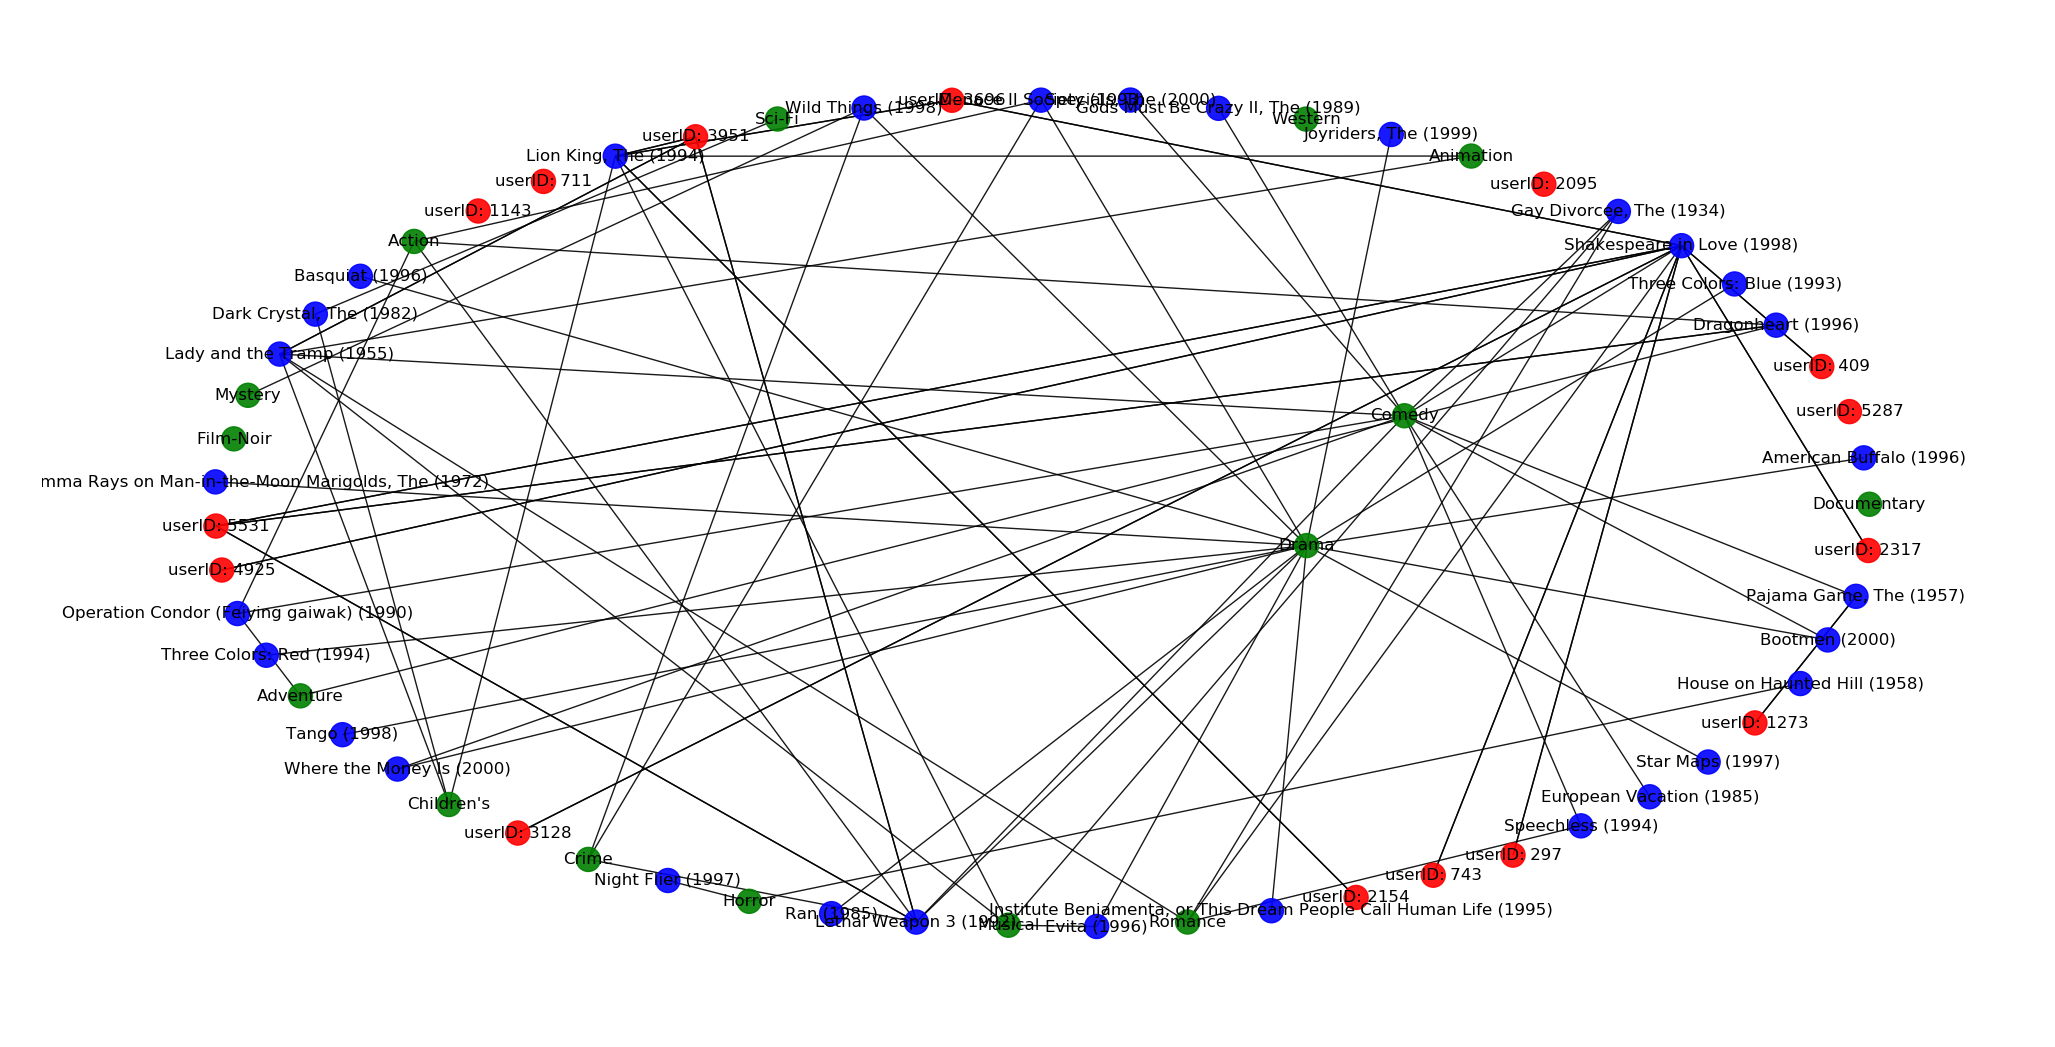

In [19]:
plt.figure(figsize=(20,10))
n_users = 15
n_movies = 30   
n_genres = 15
seed = 42

# plotting the graph
graph_path = 'ml1m.gpickle'
plot_graph(graph_path, n_users, n_movies, n_genres, seed)
plt.show()